<a href="https://colab.research.google.com/github/kyunginstevenmin/ResNetFaceClassification/blob/main/ResNet%20Face%20Classification%20Implementation%20on%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description:
This is notebook of an implementing of a ResNet model for a face classification task based on CMU 11_785 course's hw2.
<br><br>
Data set used for this task can be found on this [kaggle competition](https://www.kaggle.com/competitions/11-785-f23-hw2p2-classification).
<br><br>
This exercise consists of 1) setting up a CNN using Pytorch, 2) handling image datasets, 3) image augmentation techniques, 4) how to train a model, 5) evaluating metrics such as validation accuracy, training accuracy, Learning rate, etc during training.

The steps are organized in the following manner:
1. Configurations for Model:
2. Classification Dataset:
 - dataset is loaded
 - Image augmentation applied.
 - Data visualization
3. Build ResNet architecture
4. Training
 - configs:
    - Learning rate scheduling
    - optimizer choice
    - training metric tracking with WandB
 - run training epochs
5. Model Performance


## 1. Configurations made during project:

### Image augmentation methods.




Referred to methods described by [He et al.](https://arxiv.org/abs/1812.01187)
* image to raw pixel:
* flip horizontally with 0.5 probability.
* scale hue, saturation, and brightness
* gaussianblur
* normalize RGB channels
<br>

And transformation techniques from Convnet for 2020's: [Liu et al.]( https://arxiv.org/abs/2201.03545)

* mixup
* cutmix
* randaugment
* random erasing



### Choose training configurations:
- choice of optimizer: SGD optimizer
- learning rate schedules: CosineAnnealing with Warmup Period
- weight initialization: Xavier algorithm


### Learning rate, batchsize, and epoch

In [ ]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.5,
    'epochs': 100,
    # Include other parameters as needed.
}

In [ ]:
!nvidia-smi # to see what GPU you have

Wed Feb  5 13:58:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from torchsummary import summary
from torch import nn
from torch.nn import functional as F
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


## 2. Classification Dataset
### Load classification Dataset & set Image augmentation settings

In [ ]:
DATA_DIR    = '/content/drive/MyDrive/Colab Notebooks/CMU/HW2P2/11-785-s23-hw2p2-classification/'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html
# mean and std per channel under current transformation techniques
mean = [0.4289, 0.3656, 0.3335]
std = [0.2511, 0.2274, 0.2122]


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(degrees=10,scale=(0.7,1.3),shear=10),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    torchvision.transforms.RandomGrayscale(),
    torchvision.transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,5.)),

    torchvision.transforms.ToTensor()
    # torchvision.transforms.Normalize(mean,std)
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?
# because you want the validation data set to be representative of the test data set.

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
          # map returns an iterator that applies that lambda function to the sorted list of files in test directory.
          # lambda joins the path of data_dir with each file names of test directory.
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data? Because we want to apply the same transformation, which is no transformation, to both validation and test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 2) # same config of test_loader and valid_loader

In [ ]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7000
No. of train images  :  140000
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


In [ ]:
# mean = 0
# std = 0
# nb_sample = 0.

# for img,_ in train_loader:
#   batch_sample = img.size(0)
#   img = img.view(batch_sample, img.size(1), -1) # resizes the image to batch_sample x channel x -1
#   mean += img.mean(2).sum(0)
#   std += img.std(2).sum(0)
#   nb_sample += batch_sample

# mean /= nb_sample
# std /= nb_sample

### Data visualization

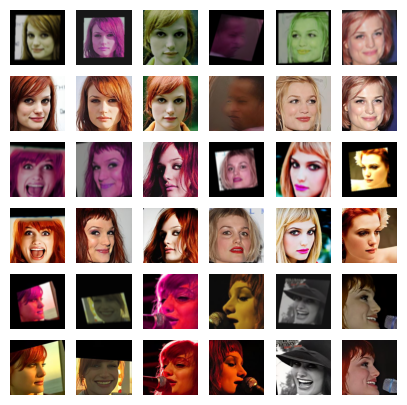

In [ ]:
# Visualize a few images in the dataset
r, c    = [6, 6]
fig, ax = plt.subplots(r, c, figsize= (5, 5))

k       = 20
dtl1     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms),
    batch_size  = config['batch_size'],
    shuffle     = False,
)

dtl2 = torch.utils.data.DataLoader(
    dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = valid_transforms), # no transform
    batch_size = config['batch_size'],
    shuffle = False
)

for data1, data2 in zip(dtl1, dtl2):
    x1, y1 = data1
    x2, y2 = data2

    for i in range(0,r,2):
        for j in range(c):
            img1, img2 = x1[k].numpy().transpose(1, 2, 0), x2[k].numpy().transpose(1,2,0)

            ax[i, j].imshow(img1)
            ax[i, j].axis('off')

            ax[i+1, j].imshow(img2)
            ax[i+1, j].axis('off')
            k+=1
    break

del dtl1
del dtl2

## 3. Model Architecture. ResNet-18
This is an implementation of the ResNet architecture first introduced by [He et al.](https://arxiv.org/abs/1512.03385).
Implementation has been adapted from Dive into Deep learning's modern CNN [chapter 8](https://d2l.ai/chapter_convolutional-modern/resnet.html).


This is a base Residual layer that will be repeatedly used in the blocks of ResNet.

In [ ]:
class Residual(nn.Module):
  """Base Residual layer"""
  def __init__(self, num_channels, use_1x1conv=False,kernel_sizes=3, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(out_channels=num_channels, kernel_size=kernel_sizes, stride=strides, padding = ((kernel_sizes-1)//2))
    self.conv2 = nn.LazyConv2d(out_channels=num_channels, kernel_size=kernel_sizes, stride=1, padding=((kernel_sizes-1)//2))

    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(out_channels=num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None

    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()


  def forward(self,x):
    Y = self.conv1(x)
    Y = self.bn1(Y)
    Y = F.relu(Y)
    Y = self.bn2(self.conv2(Y))

    if self.conv3: # transformation for identity connection if downsampling, or matching num channels of residual and identity
      x = self.conv3(x)

    Y += x # add residual and identity
    return F.relu(Y)




In [ ]:
# simple test of Residual Class
residual = Residual(11,strides=5, use_1x1conv=True)
x = torch.rand(size=(1,3,10,10))
Y = residual(x)
Y.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 11, 2, 2])

In [ ]:
class ResNet(nn.Module):
  def b1(self):
    """This is an attribute of Network that will return the stem layer."""
    return nn.Sequential(
        nn.LazyConv2d(out_channels=64,kernel_size=7, stride=2),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

  def block(self, num_residuals, num_channels, first_block=False):
    """Single block has multiple residual units, all with the same number of channels.

    The first unit is indicated has use_1x1conv = True for two reasons.
    1) Match the number of channels of input X and the output of the residuals.
    2) Downsampling is done in first unit. therefore, stride=2.

    num_residuals -- number of residual units in one block.
    num_channels -- number of channels for every residual unit is the same.
    first_block -- Set to True only first 1st Residual block of network, so that we don't down sample.
    """

    blk = []
    for i in range(num_residuals):
      if i == 0 and first_block == False: # we need to match the number of channels of identity and residual in 1st layer between blocks. but first_block doesn't apply. additionally down sampling is done on first layer of a block.
        blk.append(Residual(num_channels=num_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(Residual(num_channels=num_channels))
    return nn.Sequential(*blk)

  def __init__(self, arch, lr=0.1, num_classes=7000):
    super(ResNet, self).__init__()
    self.net = nn.Sequential(self.b1()) # stem module
    for i,b in enumerate(arch): # residual module
      self.net.add_module(name=f'b{i+2}', module=self.block(num_residuals=b[0], num_channels=b[1], first_block=(i==0)))

    self.net.add_module(name='last', module = nn.Sequential(
        nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))

    self.cls_layer = nn.Softmax()

  def forward(self, x, return_feats=False):
    """Forward propgation of network.

    for input image, it computes the final classification probabilities or the
    final embedding prior to the softmax calculation, depending on the value of
    return_feats.

    x -- input tensor of network.
    return_feats -- if true, final embedding of image returned prior to softmax.
                    if false, network returns classification probabilities."""
    feats = self.net(x)
    out = self.cls_layer(feats)

    if return_feats:
      return feats
    else:
      return out


In [ ]:
class ResNet18(ResNet):
  def __init__(self, lr=0.1, num_classes=7000):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)))

In [ ]:
model = ResNet18().to(DEVICE)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 109, 109]           9,472
       BatchNorm2d-2         [-1, 64, 109, 109]             128
              ReLU-3         [-1, 64, 109, 109]               0
         MaxPool2d-4           [-1, 64, 54, 54]               0
            Conv2d-5           [-1, 64, 54, 54]          36,928
       BatchNorm2d-6           [-1, 64, 54, 54]             128
            Conv2d-7           [-1, 64, 54, 54]          36,928
       BatchNorm2d-8           [-1, 64, 54, 54]             128
          Residual-9           [-1, 64, 54, 54]               0
           Conv2d-10           [-1, 64, 54, 54]          36,928
      BatchNorm2d-11           [-1, 64, 54, 54]             128
           Conv2d-12           [-1, 64, 54, 54]          36,928
      BatchNorm2d-13           [-1, 64, 54, 54]             128
         Residual-14           [-1, 64,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


## 4. Training

### Set up for training:
Loss function and optimizer is specified. We will use cross entropy loss, the standard loss function for classification task.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9,
                             weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler() # for mixed precision autocast

In [ ]:
len(train_loader)

2188

In [ ]:
def train(model, dataloader, optimizer, criterion):
  model.train() # sets applicable training modules to training mode: ex) BN, dropout

  # progress bar
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0,
                   desc='Train', ncols=5)

  num_correct = 0
  total_loss = 0

  for i, (images, labels) in enumerate(dataloader): # dataloader is a generater
    # the shape of images: (batchsize or num_examples, channel_no, heigh, width)
    # shape of label: (batchsize or num_examples)

    optimizer.zero_grad() #

    images, labels = images.to(DEVICE), labels.to(DEVICE) # sending data to GPU

    with torch.cuda.amp.autocast(): # auto mixed precision
      outputs = model(images, return_feats=True) # return_feats = True returns unnormalized logits prior to softmax activation. because torch.nn.CrossEntropyLoss accepts unnormlized logits as input.
      loss = criterion(outputs, labels)
      normalized_outputs = F.softmax(outputs,dim=1)

    # update no. of correction predictions and loss as we iterate
    # num_correct += int((torch.argmax))
    num_correct += int((torch.argmax(normalized_outputs, axis=1) == labels).sum()) # for every batch, num_correct instances are incremented.
    total_loss += float(loss.item())

    # tqdm lets you add some details so you can monitor training as you train.
    batch_bar.set_postfix(
        acc = "{:.04f}%".format(100*num_correct / (config['batch_size']*(i+1))),
        loss = "{:.04f}%".format(float(total_loss / (i+1))),
        num_correct= num_correct,
        lr = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

    # backward propagation and gradient descent: only in training
    scaler.scale(loss).backward() # scaler version of loss.backward(): back propgation of loss
    scaler.step(optimizer) # given the gradient, take gradient descent step according to optimizer
    scaler.update() # update scale for next iteration


    # scheduler update: scheduler changes learning rate depending on batch no
    scheduler.step()

    batch_bar.update()

  batch_bar.close() # close tqdm bar(progress bar)

  acc = 100 * num_correct / (len(dataloader) * config['batch_size']) #
  total_loss = float(total_loss / len(dataloader)) # total loss is divided by the number of batches.

  return acc, total_loss



In [ ]:

def validate(model, dataloader, criterion):
  model.train() # sets applicable training modules to training mode: ex) BN, dropout

  # progress bar
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0,
                   desc='val', ncols=5)

  num_correct = 0
  total_loss = 0

  for i, (images, labels) in enumerate(dataloader):

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.inference_mode():
      outputs = model(images, return_feats=True)
      loss = criterion(outputs, labels) # mean loss of batch returned. by default, reduction = 'mean'
      normalized_outputs = F.softmax(outputs,dim=1)

    num_correct += (torch.argmax(normalized_outputs, dim=1) == labels).sum()
    total_loss += float(loss.item())

    batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

    batch_bar.update()

  batch_bar.close()
  acc = 100 * (num_correct / (len(dataloader)*config['batch_size']))
  total_loss = float(total_loss / len(dataloader)) # mean loss

  return acc, total_loss





In [ ]:
gc.collect()
torch.cuda.empty_cache()

### Wandb

In [ ]:
wandb.login(key="") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


True

In [ ]:
run = wandb.init(
    name = "ResNet18", ## Wandb creates random run names if you skip this field
    reinit=True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations",
    config = config
    )

### Learning rate scheduling

For training we used a warm up period and CosineAnnealing learning rate scheduler to optimize training.

In [ ]:
warmup_period = 3*len(train_loader) # number of batches to warm up = 3 epochs

lambdaLr = lambda current_batch: current_batch/warmup_period # takes current T, which is the current batch no since we take scheduler step after each batch update, and divide by warm_up period

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lambdaLr)
scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = config['epochs']*len(train_loader))
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_period])



In [ ]:
scheduler.state_dict()

{'_milestones': [6564],
 'last_epoch': 0,
 '_last_lr': [0.0],
 '_schedulers': [{'base_lrs': [0.5],
   'last_epoch': 0,
   'verbose': False,
   '_step_count': 1,
   '_get_lr_called_within_step': False,
   '_last_lr': [0.0],
   'lr_lambdas': [None]},
  {'T_max': 218800,
   'eta_min': 0,
   'base_lrs': [0.5],
   'last_epoch': -1,
   'verbose': False,
   '_step_count': 1,
   '_get_lr_called_within_step': False,
   '_last_lr': [0.0]}]}

### Run training epoch

In [ ]:
best_valacc = 0.0


for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    current_batch = ((epoch-1)*len(train_loader)) + i # current batch number


    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  #'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, './checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()


Epoch 1/100: 
Train Acc 0.0050%	 Train Loss 8.8711	 Learning Rate 0.0000


Val Acc 0.0143%	 Val Loss 8.8546
Saving model



Epoch 2/100: 
Train Acc 0.0079%	 Train Loss 8.8638	 Learning Rate 0.1667


Val Acc 0.0343%	 Val Loss 8.8197
Saving model


Train: 100%|█████████▉| 2187/2188 [10:37<00:00,  4.09it/s, acc=0.0443%, loss=8.6942%, lr=0.4999, num_correct=62]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 3/100: 
Train Acc 0.0443%	 Train Loss 8.6942	 Learning Rate 0.3333


Val Acc 0.0971%	 Val Loss 8.4832
Saving model



Epoch 4/100: 
Train Acc 0.1992%	 Train Loss 8.0692	 Learning Rate 0.5000


Val Acc 0.3999%	 Val Loss 7.9522
Saving model



Epoch 5/100: 
Train Acc 0.8512%	 Train Loss 7.4117	 Learning Rate 0.4999


Val Acc 0.9769%	 Val Loss 7.4693
Saving model



Epoch 6/100: 
Train Acc 1.8253%	 Train Loss 6.9165	 Learning Rate 0.4995


Val Acc 1.9567%	 Val Loss 7.1164
Saving model



Epoch 7/100: 
Train Acc 3.3200%	 Train Loss 6.5346	 Learning Rate 0.4989


Val Acc 3.1821%	 Val Loss 6.7920
Saving model



Epoch 8/100: 
Train Acc 4.9860%	 Train Loss 6.2089	 Learning Rate 0.4980


Val Acc 4.3104%	 Val Loss 6.5537
Saving model



Epoch 9/100: 
Train Acc 6.8077%	 Train Loss 5.9239	 Learning Rate 0.4969


Val Acc 5.8872%	 Val Loss 6.3395
Saving model



Epoch 10/100: 
Train Acc 8.5423%	 Train Loss 5.6813	 Learning Rate 0.4956


Val Acc 7.1041%	 Val Loss 6.1334
Saving model



Epoch 11/100: 
Train Acc 10.4519%	 Train Loss 5.4830	 Learning Rate 0.4940


Val Acc 8.2410%	 Val Loss 5.9956
Saving model



Epoch 12/100: 
Train Acc 11.8237%	 Train Loss 5.3366	 Learning Rate 0.4921


Val Acc 9.4464%	 Val Loss 5.8675
Saving model



Epoch 13/100: 
Train Acc 13.0863%	 Train Loss 5.2121	 Learning Rate 0.4901


Val Acc 10.6604%	 Val Loss 5.6977
Saving model



Epoch 14/100: 
Train Acc 14.1332%	 Train Loss 5.1062	 Learning Rate 0.4878


val:  20%|██        | 112/547 [00:10<00:39, 11.15it/s, acc=10.4535%, loss=5.8184, num_correct=tensor(756, device='cuda:0')]

Buffered data was truncated after reaching the output size limit.

Test model output

In [ ]:
def test(model, dataloader):
  """Inference mode of model.

  Returns the model inference result Y for entire data as saved in dataloader as a list.
  """
  model.eval() # sets model to evaluation mode. for BN and dropout etc
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images, labels) in enumerate(dataloader):
    images =images.to(DEVICE)

    with torch.inference_mode(): # better performance. like no_grad()
      outputs = model(images, return_feats=False)
    outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
    test_results.extend(outputs)

    batch_bar.update()

    break
  batch_bar.close()
  return test_results


In [ ]:
test(model, train_loader)

[1337,
 6641,
 5639,
 5324,
 5453,
 4748,
 2157,
 254,
 6457,
 6761,
 6715,
 3376,
 2326,
 983,
 6936,
 5222,
 792,
 4931,
 4212,
 4500,
 4093,
 1290,
 4183,
 2198,
 652,
 2466,
 3180,
 686,
 4221,
 6334,
 5738,
 4462,
 5857,
 4223,
 5274,
 5143,
 4744,
 5955,
 5185,
 6833,
 4582,
 3222,
 5224,
 1285,
 2399,
 5414,
 6324,
 5542,
 350,
 279,
 1732,
 1917,
 5561,
 3717,
 1529,
 492,
 5928,
 5358,
 4112,
 1700,
 4250,
 4564,
 4970,
 3858]

## 5. Model Performance

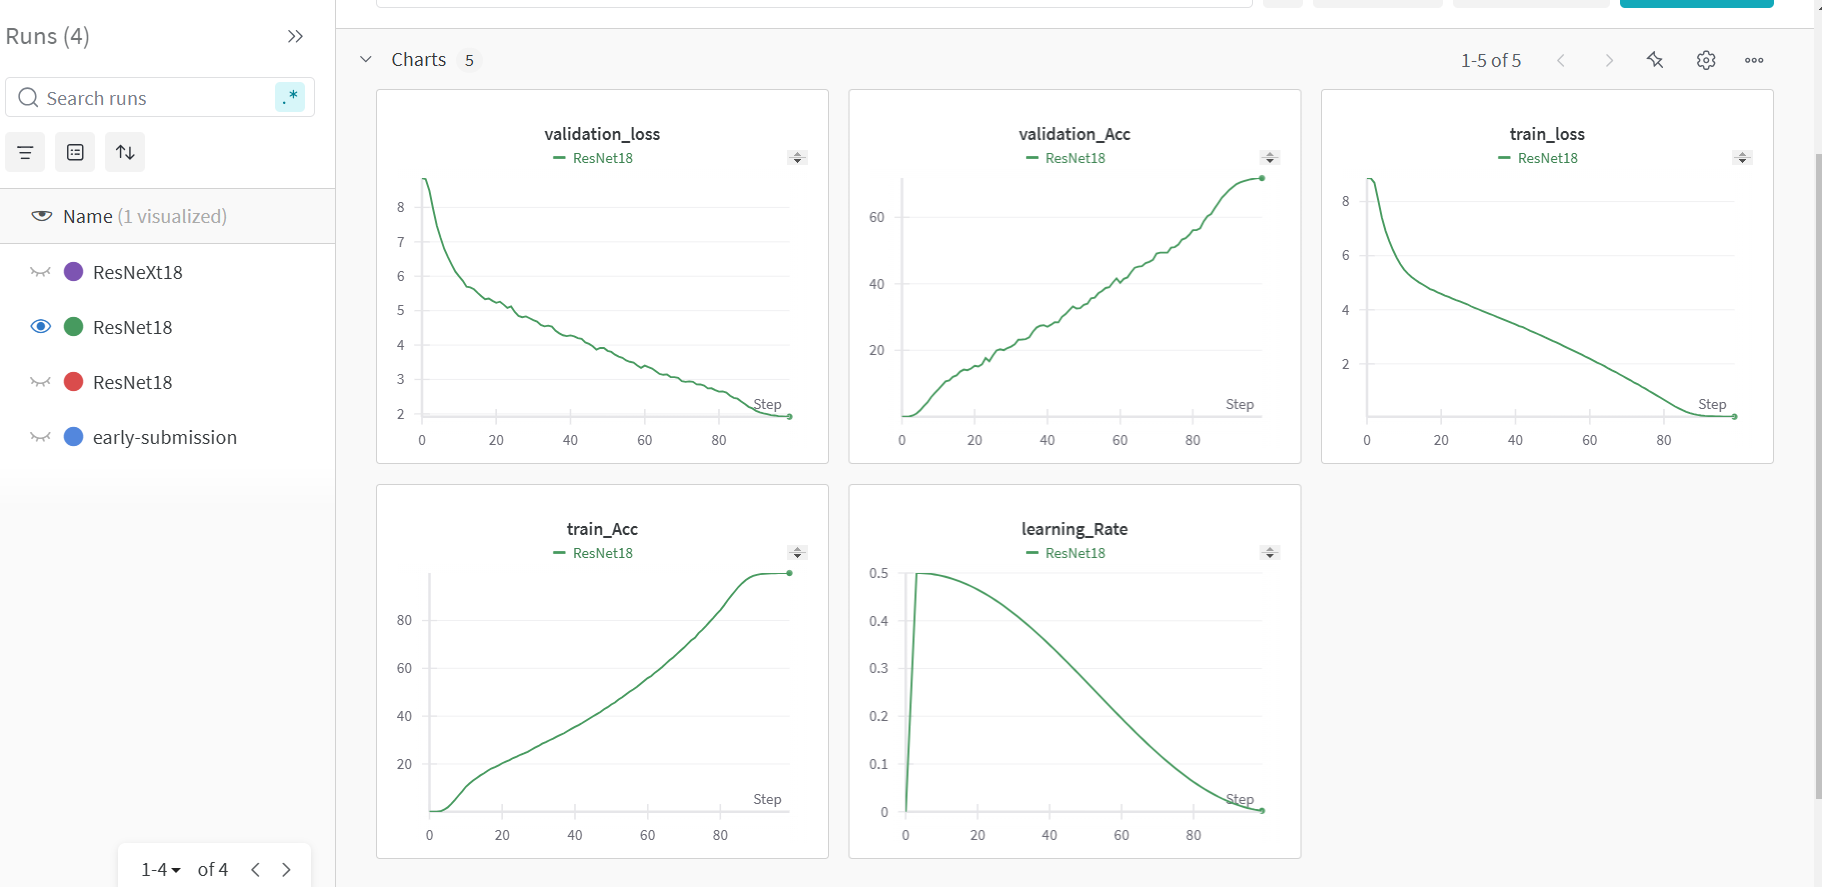